<a href="https://colab.research.google.com/github/JGCMachado/Notebooks/blob/main/MVP3_Emendas_Parlamentares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MVP de Engenharia de Dados
Profs. Victor Almeida e Silvio Alonso

##Aluno: José Guilherme Campos Machado

#1.0 Descrição

Esse trabalho é referente ao MVP da 3ª sprint (Engenharia de Dados) do curso de Pós-Graduação em Ciência de Dados e Analytics da PUC-RJ


Nele será desenvolvida uma pipeline de dados utilizando tecnologias de nuvem na plataforma da AWS. A pipeline irá conter a busca, coleta, modelagem, carga e análise dos dados.

#2.0 Objetivo escolhido

Encontrar no Portal da Transparência do governo brasileiro informações sobre as verbas destinadas pelos políticos as suas bases eleitorais.

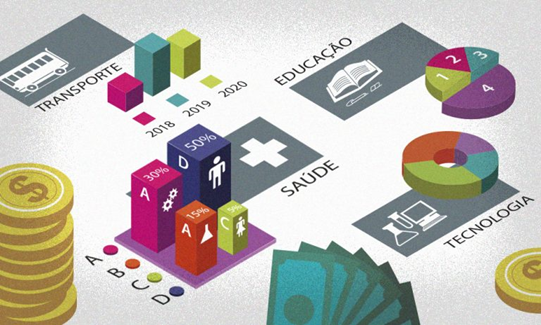

Podemos elencar como possíveis perguntas a serem respondidas:

1)	Quais políticos conseguiram aprovar mais emendas orçamentárias?

2)	Quais políticos aprovaram maiores valores?

3)	Para quais setores foram destinadas mais verbas?

4)	Quais estados receberam mais verbas?




Se for possível tentarei mapear se políticos de situação conseguem aprovar mais emendas orçamentárias que políticos de oposição.

#3.0 Detalhamento

##3.1 Busca pelos dados

Para responder as perguntas citadas acima busquei no Portal da Transparência do governo brasileiro informações detalhadas sobre emendas parlamentares referentes a orçamento.

No site existe a possibilidade de filtrar as informações, mas também existe um arquivo único com as informações disponíveis a partir de 2014.

https://portaldatransparencia.gov.br/download-de-dados/emendas-parlamentares

Optei por baixar o arquivo único



Referente a licença de uso dos dados:

(Trechos retirados do site)

####Dados Abertos

“O Portal Mapa Brasil Transparente disponibiliza as informações das consultas em formato apropriado para download e processamento. O usuário poderá baixar as informações referentes às avaliações independentes e fazer todos os cruzamentos e análises desejados.

O novo Portal da Transparência reforça, assim, com novos recursos e mais informações, sua razão de ser uma ferramenta que permita ao cidadão, de forma cada vez mais eficiente, fiscalizar e assegurar a boa e correta aplicação dos recursos públicos federais.

O acesso ao Portal não requer usuário nem senhas, sendo permitido a qualquer cidadão navegar pelas páginas de forma livre, bem como visualizar e utilizar os dados disponíveis da forma que melhor lhe convier.”


##3.2 Coleta

Apos encontrar o dataset de Emendas Parlamentares no Portal da Trasnsparência e baixa-lo passei a analizar mais a fundo o seu conteudo.


###3.2.1 Analise Exploratória

Vou carregar o arquivo para melhor conhece-lo. A importação do dataset será através do pacote Pandas (Python Data Analysis Library), um arquivo .csv com cabeçalho disponibilizado no github.


In [1]:
# Importação biblioteca Pandas
import pandas as pd

In [2]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# O arquivo já contem o cabeçalho
# Carrega a variavel com o endereço do arquivo no github que contem o dataset
filename = "https://raw.githubusercontent.com/JGCMachado/Datasets/main/emendas.csv"
delimitador = ';'

# carga do dataset adicionando os nomes das colunas
emendas = pd.read_csv(filename, delimiter=delimitador)

Verificando os dados importados percebi que o dicionário disponibilizado não estava 100% compatível com os dados do dataset. Os campos "Nome do Município", "Nome do Estado" e "Nome da Região" que constam do dicionário de dados foram substituido pelo campo "Localidade do gasto" que é mencionado como "Regionalização"

Para facilitar a realização das consultas que vão responder as questões levantadas no item 2.0 senti necessidade de criar dois campos. Um campo com a Abrangência da Emenda ("Municipal", "Estadual" ou "Nacional" e outro campo com a Sigla da UF referênte a Abrangência da Emenda sendo "BR" utilizado quando Abrangência Nacional.

As informações necessárias para as novas colunas podem ser extraidas com base no campo "Localidade do gasto". Quando a Emenda é municipal este campo contem o nome do município seguido de um "-" e a sigla do estado do município, quando é estadual contem o nome do estado seguido da string "(UF)" e quando é uma Emenda de nivel nacional contem "nacional"

Vou criar uma lista contendo os nomes dos estados e suas siglas e 2 funções para criar as novas colunas

In [4]:
# Dicionário de mapeamento de nomes de estados para siglas de UFs
mapeamento_estado_uf = {
    'ACRE': 'AC',
    'ALAGOAS': 'AL',
    'AMAPÁ': 'AP',
    'AMAZONAS': 'AM',
    'BAHIA': 'BA',
    'CEARÁ': 'CE',
    'DISTRITO FEDERAL': 'DF',
    'ESPÍRITO SANTO': 'ES',
    'GOIÁS': 'GO',
    'MARANHÃO': 'MA',
    'MATO GROSSO': 'MT',
    'MATO GROSSO DO SUL': 'MS',
    'MINAS GERAIS': 'MG',
    'PARÁ': 'PA',
    'PARAÍBA': 'PB',
    'PARANÁ': 'PR',
    'PERNAMBUCO': 'PE',
    'PIAUÍ': 'PI',
    'RIO DE JANEIRO': 'RJ',
    'RIO GRANDE DO NORTE': 'RN',
    'RIO GRANDE DO SUL': 'RS',
    'RONDÔNIA': 'RO',
    'RORAIMA': 'RR',
    'SANTA CATARINA': 'SC',
    'SÃO PAULO': 'SP',
    'SERGIPE': 'SE',
    'TOCANTINS': 'TO'
}

# Função para definir o tipo da abrangência do gasto da emenda com base na coluna Localidade do gasto
def definir_abrangencia_emenda(row):
    if '(UF)' in row['Localidade do gasto']:
        return 'Estadual'
    elif 'Nacional' in row['Localidade do gasto']:
        return 'Nacional'
    else:
        return 'Municipal'


# Função para definir o valor da coluna 'abrangencia_sigla' com base nas condições
def definir_abrangencia_sigla(localidade):
    if ' - ' in localidade:
        return localidade.split(' - ')[1]
    elif ' (UF)' in localidade:
        estado = localidade.split(' (UF)')[0]
        return mapeamento_estado_uf.get(estado, estado)  # Usar o mapeamento para obter a sigla da UF
    elif 'Nacional' in localidade:
        return 'BR'
    else:
        return None  # Caso padrão, pode ser ajustado conforme necessário


In [5]:
# verifica o tipo do dataset heart_disease
print(type(emendas))

<class 'pandas.core.frame.DataFrame'>


In [6]:
# exibe as primeiras linhas para verificar se a importação ocorreu de acordo com o esperado
emendas.head(5)

,Código da Emenda,Ano da Emenda,Tipo de Emenda,Código do Autor da Emenda,Nome do Autor da Emenda,Número da emenda,Localidade do gasto,Código Função,Nome Função,Código Subfunção,Nome Subfunção,Valor Empenhado,Valor Liquidado,Valor Pago,Valor Restos A Pagar Inscritos,Valor Restos A Pagar Cancelados,Valor Restos A Pagar Pagos
0,Sem informação,2014,Emenda Individual,S/I,Sem informação,S/I,SÃO JOÃO DO CARÚ - MA,10,Saúde,301,Atenção básica,1253150,0,0,0,0,1253150
1,Sem informação,2014,Emenda Individual,S/I,Sem informação,S/I,BORBA - AM,10,Saúde,122,Administração geral,999958,0,0,0,0,999958
2,Sem informação,2014,Emenda Individual,S/I,Sem informação,S/I,Nacional,13,Cultura,392,Difusão cultural,"1665560,68",150860,0,0,"243083,14","1422477,54"
3,Sem informação,2014,Emenda Individual,S/I,Sem informação,S/I,MARANHÃO (UF),18,Gestão ambiental,544,Recursos hídricos,500000,0,0,0,500000,0
4,Sem informação,2014,Emenda Individual,S/I,Sem informação,S/I,PERNAMBUCO (UF),10,Saúde,302,Assistência hospitalar e ambulatorial,"23826320,09",0,0,0,"6463502,51","17362817,58"


In [7]:
# Mostra as dimensões do dataset
print(emendas.shape)

(59138, 17)


###3.2.2 Inclusão das colunas

Inclusão das colunas 'Abrangencia Emenda' e 'Abrangencia Sigla' baseadas no conteudo da coluna 'Localidade do gasto'

In [9]:
# Aplicar a função para criar a coluna 'Abrangencia Emenda'
emendas['Abrangencia Emenda'] = emendas.apply(definir_abrangencia_emenda, axis=1)

In [10]:
# Aplicar a função para criar a coluna 'Abrangencia Sigla'
emendas['Abrangencia Sigla'] = emendas['Localidade do gasto'].apply(definir_abrangencia_sigla)


In [12]:
# exibe as primeiras linhas para confirmar a inclusão das colunas
emendas.head(5)

,Código da Emenda,Ano da Emenda,Tipo de Emenda,Código do Autor da Emenda,Nome do Autor da Emenda,Número da emenda,Localidade do gasto,Código Função,Nome Função,Código Subfunção,Nome Subfunção,Valor Empenhado,Valor Liquidado,Valor Pago,Valor Restos A Pagar Inscritos,Valor Restos A Pagar Cancelados,Valor Restos A Pagar Pagos,Abrangencia Emenda,Abrangencia Sigla
0,Sem informação,2014,Emenda Individual,S/I,Sem informação,S/I,SÃO JOÃO DO CARÚ - MA,10,Saúde,301,Atenção básica,1253150,0,0,0,0,1253150,Municipal,MA
1,Sem informação,2014,Emenda Individual,S/I,Sem informação,S/I,BORBA - AM,10,Saúde,122,Administração geral,999958,0,0,0,0,999958,Municipal,AM
2,Sem informação,2014,Emenda Individual,S/I,Sem informação,S/I,Nacional,13,Cultura,392,Difusão cultural,"1665560,68",150860,0,0,"243083,14","1422477,54",Nacional,BR
3,Sem informação,2014,Emenda Individual,S/I,Sem informação,S/I,MARANHÃO (UF),18,Gestão ambiental,544,Recursos hídricos,500000,0,0,0,500000,0,Estadual,MA
4,Sem informação,2014,Emenda Individual,S/I,Sem informação,S/I,PERNAMBUCO (UF),10,Saúde,302,Assistência hospitalar e ambulatorial,"23826320,09",0,0,0,"6463502,51","17362817,58",Estadual,PE


In [13]:
# Mostra as informações do dataset
print(emendas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59138 entries, 0 to 59137
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Código da Emenda                 59138 non-null  object
 1   Ano da Emenda                    59138 non-null  int64 
 2   Tipo de Emenda                   59138 non-null  object
 3   Código do Autor da Emenda        59138 non-null  object
 4   Nome do Autor da Emenda          59138 non-null  object
 5   Número da emenda                 59138 non-null  object
 6   Localidade do gasto              59138 non-null  object
 7   Código Função                    59138 non-null  object
 8   Nome Função                      59138 non-null  object
 9   Código Subfunção                 59138 non-null  object
 10  Nome Subfunção                   59138 non-null  object
 11  Valor Empenhado                  59138 non-null  object
 12  Valor Liquidado                 

O total de registros do novo campo Abrangência Sigla é menor porque para as emendas parlamentares de âmbito nacional o conteudo do campo é nulo.

###3.2.3 Inclusão das colunas

Nessa sessão o dataset é salvo no disco efêmero do Colab. Na sequencia realizei um download do mesmo para subir em um Bucket S3 no ambiente da AWS


In [14]:
# Salvar o DataFrame como um arquivo CSV com codificação UTF-8
emendas.to_csv('emendas_parlamentares.csv', sep=';', index=False, encoding='utf-8-sig')

##3.3 Modelagem.




